> # __CF-OPT__ | Counterfactual Explanations for Data-Driven Optimization Pipelines
> ## Shortest paths on _Warcraft_ maps : __Workflow__

We use the framework provided by __Bo Tang__, __Elias B.__ and __Khalil__ _via_ their [PyEPO: A PyTorch-based End-to-End Predict-then-Optimize Tool](https://github.com/khalil-research/PyEPO) GitHub repository.

The [dataset](https://edmond.mpdl.mpg.de/dataset.xhtml?persistentId=doi:10.17617/3.YJCQ5S) comes from the _Warcraft 2_ tileset, and is used by Vlastelica, Martin _et al._ in the paper [_Differentiation of Blackbox Combinatorial Solvers_](https://arxiv.org/abs/1912.02175). It is composed of ten thousand $96 \times 96$ __RGB__ images, each representing a map ( along with the corresponding true costs, true shortest path and its length, but we will not use these ).

The Data-Driven Optimization Pipeline we consider here is the following :

* The prediction part of the pipeline is composed of a trained __Convolutional Neural Network__, that takes a _Warcraft_ map as input, and outputs a $12 \times 12$ tile containing the __predicted costs__ of crossing the corresponding regions of the map.

* The optimization part of the model corresponds to the use of a __Linear Programming solver__ (_Gurobi_), with the predicted costs as input, and the corresponding __shortest path__ from the upper left corner to the lower right corner of the map as output.

We use this pipeline to visually and technically illustrate the purpose and use of __CF-OPT__: finding closest __Counterfactual Explanations__ for the model.

Here, this translates into the following : finding the closest alternative _Warcraft_ map such that the output of the pipeline ( the shortest path outputted by the solver ) is different.

* For __Relative Explanations__, we seek for a map that makes a given alternative path __better__ than the initial shortest path.

* For __Absolute Explanations__, we seek for a map that makes a given alternative path __optimal__.

* For $ \varepsilon $ __-Explanations__, we do not provide an alternative path, but only seek for a map that makes the initial shortest path a decision with a __relative optimality gap__ of at least $ \varepsilon $.

## __Setting up__ the Pipeline

A few preliminary steps are necessary to set up the pipeline to explain :

* Loading the __data__,

* Setting up the __optimization solver__,

* Setting up the __CNN__ ( you can train it from scratch or simply load the weights if a model save of the same architecture is available ).

#### Imports

In [ ]:
import torch
import torch.nn as nn
import numpy as np

#### Device

In [2]:
device = "cpu"

#### Datasets and DataLoaders

In [ ]:
# Imports
from src.dataloading.dataloader import get_dataloaders_and_dataset

In [4]:
# Datasets & Dataloaders creation
(dataset_train_cnn, dataset_test_cnn,
 loader_train_cnn, loader_test_cnn,
 loader_train_vae, loader_test_vae) = get_dataloaders_and_dataset()

#### Shortest Path Optimization Model

In [5]:
# Imports
from src.optimization.ShortestPathModel import ShortestPathModel

In [ ]:
# Grid and optimization model
grid = (12,12)
optmodel = ShortestPathModel(grid, task="warcraft")

#### Prediction model: Convolutional Neural Network

##### Initializing the CNN

In [7]:
# Imports
from src.prediction.prediction_models import PartialResNet
from src.prediction.train_prediction_model import train_prediction_model

In [8]:
# Initialize CNN
cnn = PartialResNet(k=12)

##### Training the CNN from scratch <span style="color:red">( Caution : very long execution time. You can also skip and directly load a trained model )</span>

In [9]:
%load_ext tensorboard

In [ ]:
train_prediction_model(cnn, optmodel, loader_train_cnn, loader_test_cnn, 0, 100, 3e-4, device, write_tb=False, use_spo_loss=True)
cnn.eval()

##### Else: Loading the CNN

In [ ]:
cnn.load_state_dict(torch.load("models/cnn_model_saves/CNN_SPO_epoch_40.pth", map_location=device))
cnn.eval()

##### Freezing the weights of the CNN

In [10]:
for param in cnn.parameters():
    param.requires_grad = False

## __Visualizing__ the Steps of the Pipeline

Here, we plot some  _Warcraft_ maps, the corresponding CNN-predicted costs, and the corresponding shortest paths as outputted by the optimization solver, in order to visualize better what is flowing through the pipeline we will explain.

#### Warcraft Maps

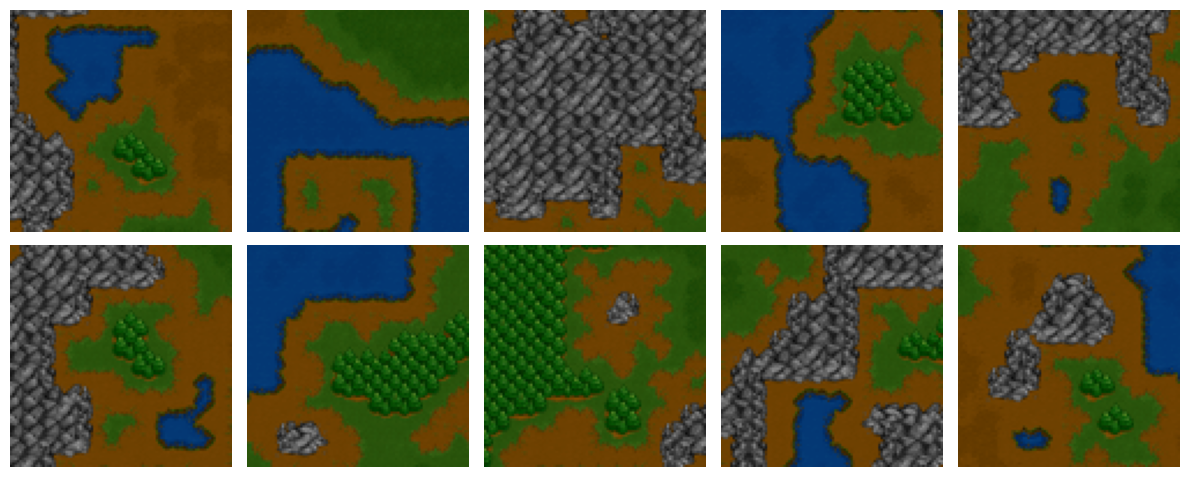

In [11]:
import matplotlib.pyplot as plt
import random

indices = random.sample(range(0, 10000), 10)

fig, axes = plt.subplots(2, 5, figsize=(12, 5))

for i, index in enumerate(indices):
    
    (warcraft_map, _, _, _) = dataset_train_cnn[index]
    map_array = warcraft_map.numpy().transpose((1, 2, 0))

    row, col = divmod(i, 5)
    axes[row, col].imshow(map_array)
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()


#### CNN-Predicted Costs

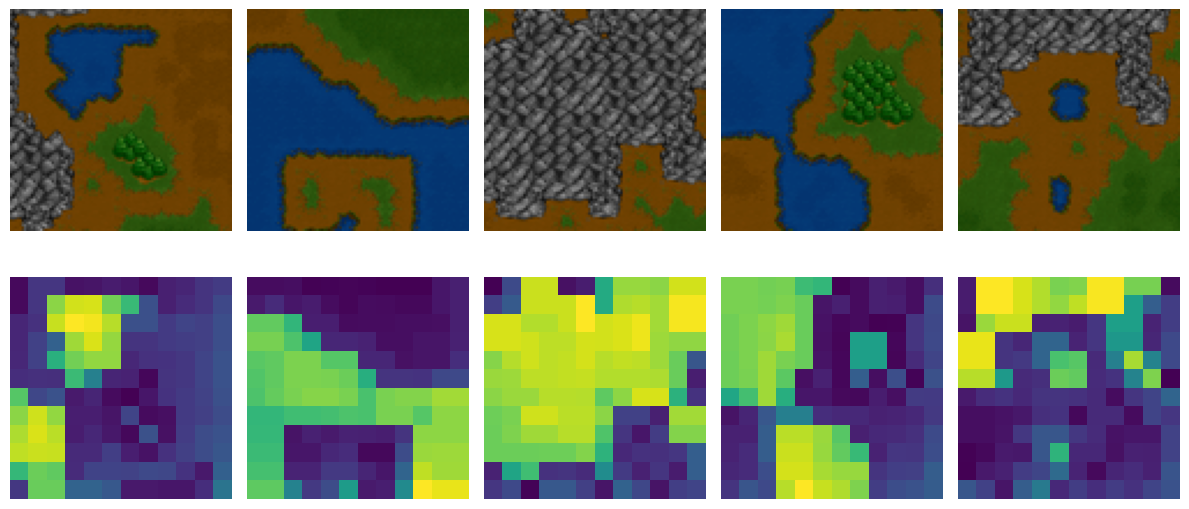

In [13]:
fig, axes = plt.subplots(2, 5, figsize=(12, 6))

for i, index in enumerate(indices[:5]):
    
    (warcraft_map, _, _, _) = dataset_train_cnn[index]
    predicted_costs = cnn(warcraft_map.unsqueeze(0)).squeeze().detach()
    predicted_costs = nn.Unflatten(0, (12, 12))(predicted_costs)
    costs_array = predicted_costs.numpy()
    map_array = warcraft_map.permute(1,2,0).numpy()

    axes[0, i].imshow(map_array)
    axes[0, i].axis('off')

    axes[1, i].imshow(costs_array)
    axes[1, i].axis('off')
    

plt.tight_layout()
plt.show()


#### Shortest Paths

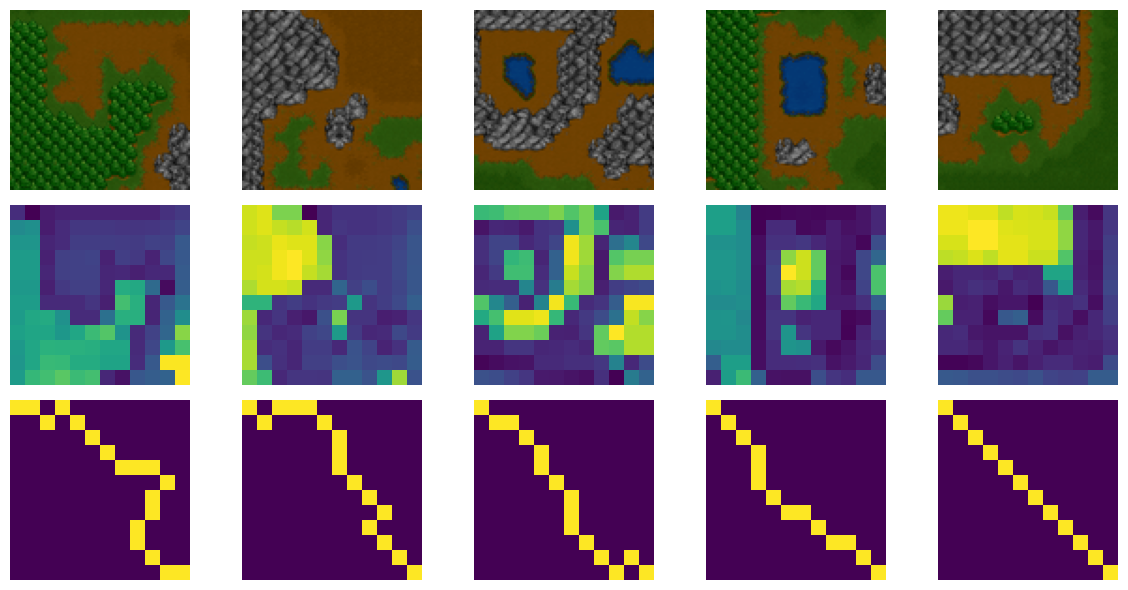

In [13]:
import gurobipy as gp

from src.counterfactual.solve import solve
from src.optimization.ShortestPathModel import ShortestPathModel

grid = (12, 12)

with gp.Env(empty=True) as env:
    env.setParam('OutputFlag', 0)
    env.start()

    with ShortestPathModel(grid, env=env, task="warcraft") as short_path_model:

        fig, axes = plt.subplots(3, 5, figsize=(12, 6))

        for i, index in enumerate(indices[:5]):
            
            (warcraft_map, _, _, _) = dataset_train_cnn[index]
            predicted_costs = cnn(warcraft_map.unsqueeze(0)).squeeze().detach()
            shortest_path, _ = solve(predicted_costs ,short_path_model, "warcraft")
            
            predicted_costs = nn.Unflatten(0, (12, 12))(predicted_costs)
            costs_array = predicted_costs.numpy()
            
            shortest_path = nn.Unflatten(0, (12, 12))(shortest_path)
            path_array = shortest_path.numpy()
            map_array = warcraft_map.permute(1,2,0).numpy()

            axes[0, i].imshow(map_array)
            axes[0, i].axis('off')

            axes[1, i].imshow(costs_array)
            axes[1, i].axis('off')

            axes[2, i].imshow(path_array)
            axes[2, i].axis('off')

        plt.tight_layout()
        plt.show()

## __Explaining__ the Pipeline with __CF-OPT__

Now that the _Warcraft_ pipeline is set up and that we visually understand what it constists of, we will provide __Counterfactual Explanations__ for it with __CF-OPT__.

#### Variational Autoencoder (VAE)

##### Initialize VAE

You can change the size of the latent space of the VAE by changing the argument at initialization. Here, we chose $64$ because it works pretty well, and it is greater than $32$.

In [14]:
# Imports
from src.vae.Vae import Vae
from src.vae.train_vae import train_cost_aware_vae

In [15]:
vae = Vae(64)

##### Train VAE from scratch <span style="color:red">( Caution : long execution time. You can also skip and directly load a trained model )</span>

In [ ]:
train_cost_aware_vae(vae, cnn, loader_train_vae, loader_test_vae, 0, 70, 3e-4, device, False, alpha=2)
vae.eval()

##### Load VAE

In [ ]:
vae.load_state_dict(torch.load("models/vae_model_saves/cost_2_VAE_64_epoch_100.pth", map_location=device))
vae.eval()

##### Freezing the weights of the VAE

In [17]:
for param in vae.parameters():
    param.requires_grad = False
vae = vae.to("cpu")

#### Some maps and their VAE-reconstruction

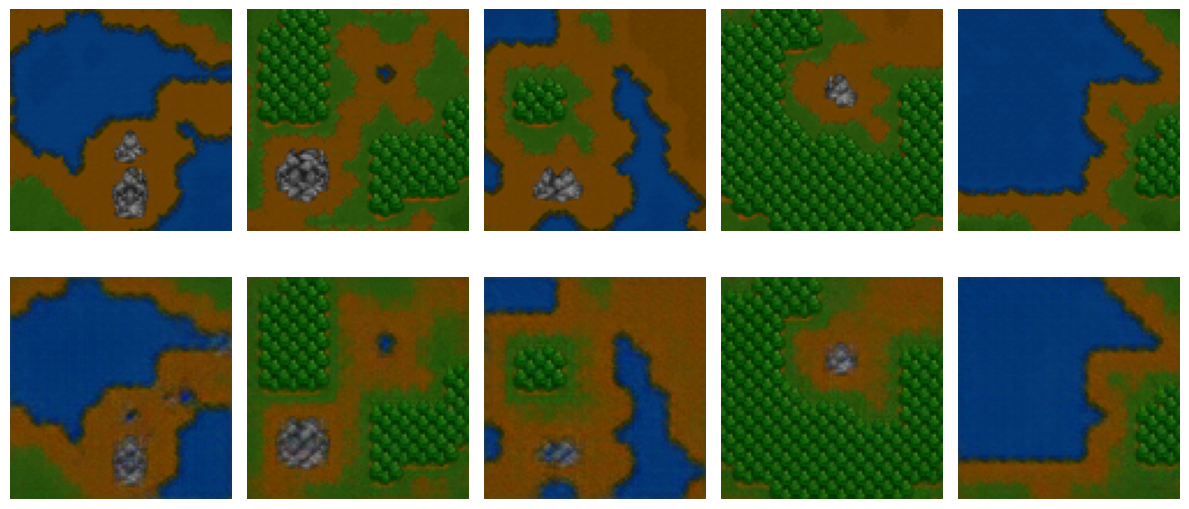

In [18]:
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
indices = [random.randint(0, len(dataset_test_cnn)-1) for i in range(10)]
for i, index in enumerate(indices[:5]):
    
    (warcraft_map, _, _, _) = dataset_train_cnn[index]
    warcraft_map = warcraft_map
    reconstructed_map = vae(warcraft_map.unsqueeze(0)).squeeze().detach().permute(1,2,0)
    reconstructed_map_array = reconstructed_map.numpy()
    initial_map_array = warcraft_map.permute(1,2,0).numpy()

    axes[0, i].imshow(initial_map_array)
    axes[0, i].axis('off')

    axes[1, i].imshow(reconstructed_map_array)
    axes[1, i].axis('off')
    

plt.tight_layout()
plt.show()

#### Some randomly generated maps

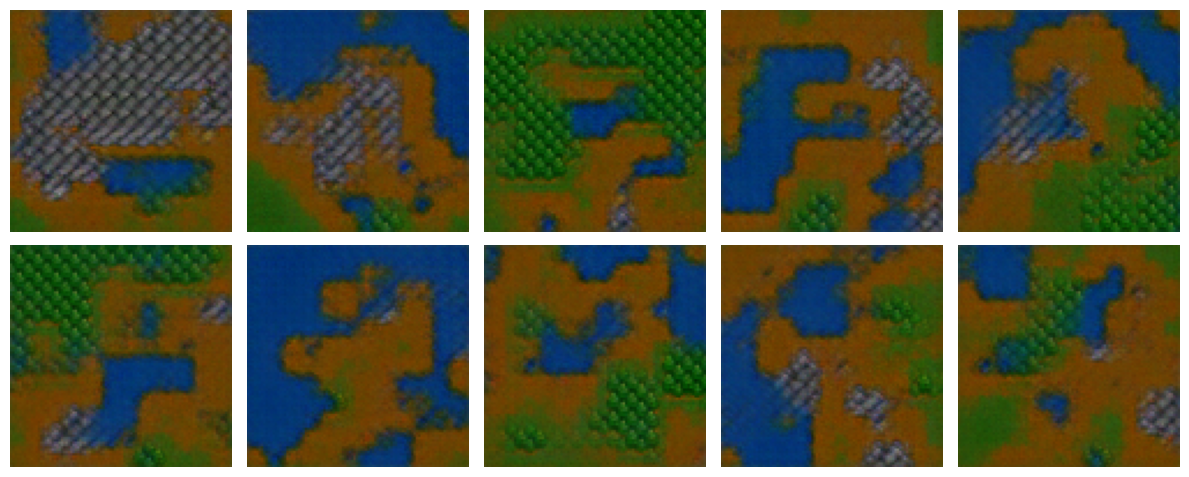

In [21]:
fig, axes = plt.subplots(2, 5, figsize=(12, 5))

for i in range(10):
    
    z = torch.normal(mean = 0, std = 1.0, size=(1,64))
    warcraft_map = vae.decoder(z).squeeze()
    map_array = warcraft_map.numpy().transpose((1, 2, 0))

    row, col = divmod(i, 5)
    axes[row, col].imshow(map_array)
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

### Running  __CF-OPT__

To run __CF-OPT__, we use the following function:
* `get_counterfactual` : Uses a modified version of the [_MDMM_](https://proceedings.neurips.cc/paper_files/paper/1987/file/a87ff679a2f3e71d9181a67b7542122c-Paper.pdf) optimization method ( performs gradient descent on the input and gradient ascent on the Lagrange multiplier at each step ) from Platt and Barr in order to obtain the counterfactual explanation. The implementation of the MDMM used comes from [this](https://github.com/crowsonkb/mdmm/tree/master) GitHub repository. This method needs the user to set only very few hyperparameters.

An `initial_index` and an `alternative_index` are required to run the function. 

The `initial_index` represents the index ( in the test dataset ) of the initial _Warcraft_ map, and consequently of its associated predicted costs and predicted shortest path. 

The `alternative_index` represents the index of another _Warcraft_ map in the test dataset, but is only used to query its associated true shortest path : it will be the __alternative decision__ in the counterfactual explanation process. 

Thus, the `alternative_index` is not used if the `explanation_type` is set to `epsilon` ( as $\varepsilon$-explanations do not require an alternative decision ).

In [22]:
# Imports
from src.counterfactual.cf_opt import get_counterfactual

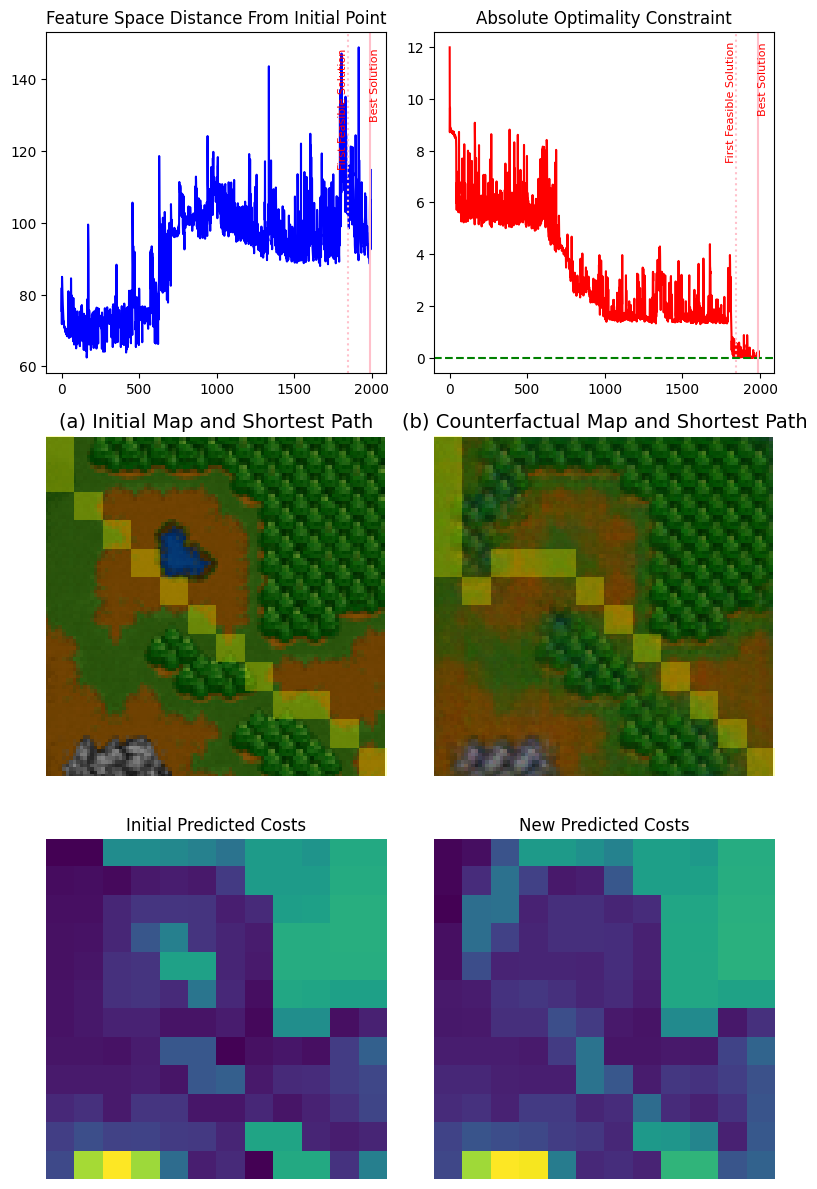

(89.36686706542969, 1994, 0.0)

In [23]:
get_counterfactual(vae=vae, 
                   pred_model=cnn, 
                   dataset=dataset_test_cnn, 
                   initial_index=12, 
                   alternative_index=68, 
                   explanation_type="absolute", 
                   objective="feature",
                   epsilon = 1, 
                   plausibility_reg="sphere",
                   step_size=0.003,
                   beta = 10,
                   plot_style = "superposed", 
                   return_sol=False)

## Numerical __Experiments__

In [21]:
import matplotlib.pyplot as plt
import random as rd
from tqdm import tqdm

### Loading __Models__

In [ ]:
vae_0 = Vae(64)
vae_0.load_state_dict(torch.load("models/vae_model_saves/VAE_64_epoch_35.pth", map_location=device))
vae_0.eval()
for param in vae_0.parameters():
    param.requires_grad = False
vae_0.to(device)

vae_01 = Vae(64)
vae_01.load_state_dict(torch.load("models/vae_model_saves/cost_0.1_VAE_64_epoch_40.pth", map_location=device))
vae_01.eval()
for param in vae_01.parameters():
    param.requires_grad = False
vae_01.to(device)

vae_02 = Vae(64)
vae_02.load_state_dict(torch.load("models/vae_model_saves/cost_0.2_VAE_64_epoch_50.pth", map_location=device))
vae_02.eval()
for param in vae_02.parameters():
    param.requires_grad = False
vae_02.to(device)

vae_03 = Vae(64)
vae_03.load_state_dict(torch.load("models/vae_model_saves/cost_0.3_VAE_64_epoch_65.pth", map_location=device))
vae_03.eval()
for param in vae_03.parameters():
    param.requires_grad = False
vae_03.to(device)

vae_05 = Vae(64)
vae_05.load_state_dict(torch.load("models/vae_model_saves/cost_0.5_VAE_64_epoch_65.pth", map_location=device))
vae_05.eval()
for param in vae_05.parameters():
    param.requires_grad = False
vae_05.to(device)

vae_07 = Vae(64)
vae_07.load_state_dict(torch.load("models/vae_model_saves/cost_0.7_VAE_64_epoch_65.pth", map_location=device))
vae_07.eval()
for param in vae_07.parameters():
    param.requires_grad = False
vae_07.to(device)

vae_1 = Vae(64)
vae_1.load_state_dict(torch.load("models/vae_model_saves/cost_1_VAE_64_epoch_70.pth", map_location=device))
vae_1.eval()
for param in vae_1.parameters():
    param.requires_grad = False
vae_1.to(device)

vae_2 = Vae(64)
vae_2.load_state_dict(torch.load("models/vae_model_saves/cost_2_VAE_64_epoch_100.pth", map_location=device))
vae_2.eval()
for param in vae_2.parameters():
   param.requires_grad = False
vae_2.to(device)

vae_3 = Vae(64)
vae_3.load_state_dict(torch.load("models/vae_model_saves/cost_3_VAE_64_epoch_100.pth", map_location=device))
vae_3.eval()
for param in vae_3.parameters():
    param.requires_grad = False
vae_3.to(device)

vae_5 = Vae(64)
vae_5.load_state_dict(torch.load("models/vae_model_saves/cost_5_VAE_64_epoch_80.pth", map_location=device))
vae_5.eval()
for param in vae_5.parameters():
    param.requires_grad = False
vae_5.to(device)

vae_10 = Vae(64)
vae_10.load_state_dict(torch.load("models/vae_model_saves/cost_10_VAE_64_epoch_80.pth", map_location=device))
vae_10.eval()
for param in vae_10.parameters():
    param.requires_grad = False
vae_10.to(device)

### __Prior Approximation__ of the True Encoded Data Distribution

In [22]:
from scipy.stats import chi
from scipy import special

In [25]:
embedded_norms = []
for _, data in enumerate(loader_train_vae):
    input, _ = data
    embedded_norms += torch.norm(vae_2.encoder(input)[0], dim=1).tolist()

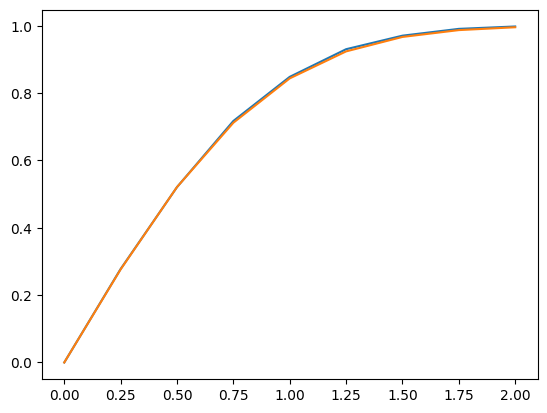

In [26]:
def experimental_proba(kappa):
    return np.mean(np.abs(embedded_norms - (2**0.5)*(special.gamma((64+1)/2)/special.gamma(64/2)))<=kappa)

def true_prior_proba(kappa):
    return chi.cdf((2**0.5)*(special.gamma((64+1)/2)/special.gamma(64/2))+kappa, df=64) - chi.cdf((2**0.5)*(special.gamma((64+1)/2)/special.gamma(64/2))-kappa, df=64)

Kappa = np.array([0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0])
plt.plot(Kappa, [experimental_proba(k) for k in Kappa])
plt.plot(Kappa, true_prior_proba(Kappa))

In [27]:
true_prior_proba(Kappa)

array([0.        , 0.27644931, 0.52087385, 0.71184477, 0.84357007,
       0.9236974 , 0.96664781, 0.98693889, 0.99540422])

In [28]:
[experimental_proba(k) for k in Kappa]

[0.0, 0.2776, 0.5207, 0.7171, 0.8481, 0.9302, 0.9704, 0.9906, 0.9977]

### Hypersphere as __optimal plausibility region__

In [1]:
import numpy as np
import math
from scipy import special
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm

In [2]:
def crit(a, b, n, eta):
    return (a**2)*special.gammainc(n/2, (a**2)/2) + (b**2)*special.gammaincc(n/2, (b**2)/2) - (2**0.5)*(special.gamma((n+1)/2)/special.gamma(n/2))*(2*a*special.gammainc((n+1)/2, (a**2)/2) + 2*b*special.gammaincc((n+1)/2, (b**2)/2)) + n*(special.gammainc((n+2)/2, (a**2)/2) + special.gammaincc((n+2)/2, (b**2)/2)) + eta*((b**n - a**n)/special.gamma((n/2)+1))*(np.pi**(n/2))

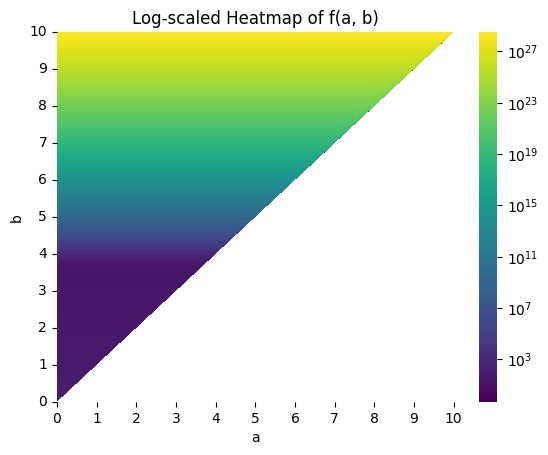

optimal a:  7.968796879687969
optimal b:  7.968796879687969


In [3]:
a = np.linspace(0, 10, 10000)
b = np.linspace(0, 10, 10000)
A, B = np.meshgrid(a, b)

Z = crit(A, B, 64, 1e-16)

Z[A > B] = np.nan

plt.figure()
ax = sns.heatmap(Z, cmap='viridis', norm=LogNorm())
ax.invert_yaxis()

unique_x_values = np.unique(a.astype(int))
unique_y_values = np.unique(b.astype(int))[::-1]

# Calculate the indices of these unique values in the original arrays
x_ticks_positions = np.searchsorted(a, unique_x_values)
y_ticks_positions = np.searchsorted(b, unique_y_values)

# Set ticks and labels for both axes
plt.xticks(x_ticks_positions, unique_x_values, rotation='horizontal')
plt.yticks(y_ticks_positions, unique_y_values)
plt.xlabel('a')
plt.ylabel('b')
plt.title('Log-scaled Heatmap of f(a, b)')
plt.show()

min_index = np.unravel_index(np.nanargmin(Z), Z.shape)
a_min = a[min_index[1]]
b_min = b[min_index[0]]
print("optimal a: ", a_min)
print("optimal b: ", b_min)

### __Stability__ metric

We define here the stability metric proposed in the paper, i.e. the relative regret of the initial optimal path (the path which is optimal before reconstruction) in the reconstructed context

In [31]:
def get_relative_regret_vae(vae, pred_model, dataset, index, shortest_path_model, use_true_costs):
    with torch.no_grad():
        initial_context = dataset[index][0].unsqueeze(0)

        if use_true_costs:
            initial_w = dataset[index][2]
        else:
            cp = pred_model(initial_context)
            initial_w, _ = solve(cp.squeeze(), shortest_path_model, task = "warcraft")

        latent_context = vae.encoder(initial_context)[0]
        reconstructed_context = vae.decoder(latent_context)
        reconstructed_cp = pred_model(reconstructed_context)
        
        initial_w_length = torch.dot(reconstructed_cp.squeeze(), initial_w)
        _, new_w_length = solve(reconstructed_cp.squeeze(), shortest_path_model, task = "warcraft")

    return (initial_w_length - new_w_length) / new_w_length
            

### Impact of the __Cost-Aware regularization__

#### __Stability__ metric

In [ ]:
VAE_relative_regret_true_costs = [[None] * 1000 for _ in range(11)]
VAE_relative_regret_predicted_costs = [[None] * 1000 for _ in range(11)]

with gp.Env(empty=True) as env:
    env.setParam('OutputFlag', 0)
    env.start()
    with ShortestPathModel((12,12), env=env, task="warcraft") as short_path_model:
        for i, vae_model in enumerate([vae_0, vae_01, vae_02, vae_03, vae_05, vae_07, vae_1, vae_2, vae_3, vae_5, vae_10]):
            for j in tqdm(range(len(dataset_test_cnn))):
                VAE_relative_regret_true_costs[i][j] = get_relative_regret_vae(vae_model, cnn, dataset_test_cnn, j, short_path_model, True)
                VAE_relative_regret_predicted_costs[i][j] = get_relative_regret_vae(vae_model, cnn, dataset_test_cnn, j, short_path_model, False)
    

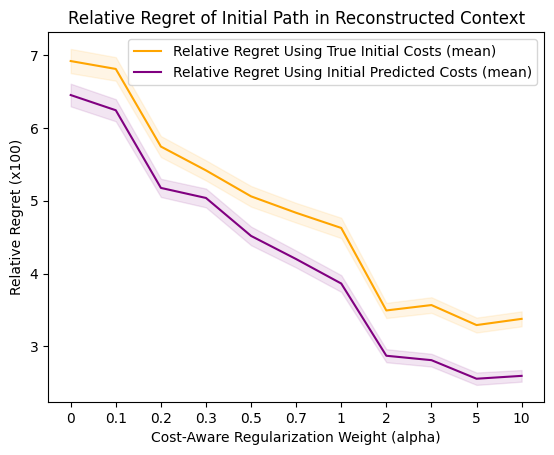

In [ ]:
relative_regret_true_costs_mean = 100*np.mean(VAE_relative_regret_true_costs, axis=1)
relative_regret_true_costs_std = 100*np.std(VAE_relative_regret_true_costs, axis=1)

relative_regret_predicted_costs_mean = 100*np.mean(VAE_relative_regret_predicted_costs, axis=1)
relative_regret_predicted_costs_std = 100*np.std(VAE_relative_regret_predicted_costs, axis=1)

plt.plot(relative_regret_true_costs_mean, label='Relative Regret Using True Initial Costs (mean)', color='orange')
plt.fill_between(range(len(relative_regret_true_costs_mean)), relative_regret_true_costs_mean - 1.96 * relative_regret_true_costs_std/100, relative_regret_true_costs_mean + 1.96 * relative_regret_true_costs_std/100, color='orange', alpha=0.1)

plt.plot(relative_regret_predicted_costs_mean, label='Relative Regret Using Initial Predicted Costs (mean)', color='purple')
plt.fill_between(range(len(relative_regret_predicted_costs_mean)), relative_regret_predicted_costs_mean - 1.96 * relative_regret_predicted_costs_std/100, relative_regret_predicted_costs_mean + 1.96 * relative_regret_predicted_costs_std/100, color='purple', alpha=0.1)

# Customize the plot as needed
plt.xticks(range(11), [0, 0.1, 0.2, 0.3, 0.5, 0.7, 1, 2, 3, 5, 10])
plt.xlabel('Cost-Aware Regularization Weight (alpha)')
plt.ylabel('Relative Regret (x100)')
plt.title('Relative Regret of Initial Path in Reconstructed Context')
plt.legend()

# Show the plot
plt.show()

#### __Reconstruction__ performances

In [ ]:
VAE_reconstruction = [[None] * 1000 for _ in range(11)]

for i, vae_model in enumerate([vae_0, vae_01, vae_02, vae_03, vae_05, vae_07, vae_1, vae_2, vae_3, vae_5, vae_10]):
    for j in tqdm(range(len(dataset_test_cnn))):
        x = dataset_test_cnn[j][0].unsqueeze(0)
        VAE_reconstruction[i][j] = nn.MSELoss(reduction="sum")(x, vae_model.decoder(vae_model.encoder(x)[0]))
    

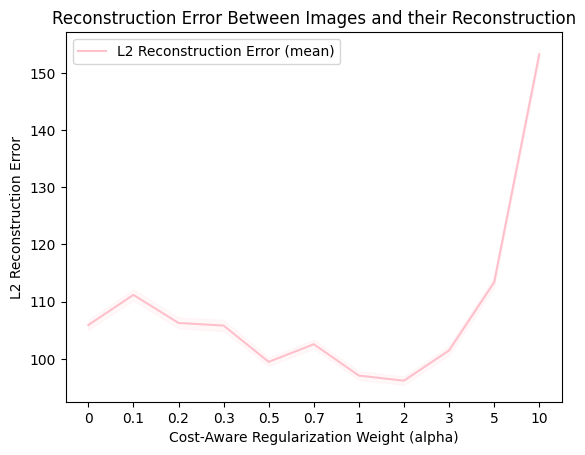

In [ ]:
reconstruction_mean = np.mean(VAE_reconstruction, axis=1)
reconstruction_std = np.std(VAE_reconstruction, axis=1)

plt.plot(reconstruction_mean, label='L2 Reconstruction Error (mean)', color='pink')
plt.fill_between(range(len(reconstruction_mean)), reconstruction_mean - 1.96 * reconstruction_std/100, reconstruction_mean + 1.96 * reconstruction_std/100, color='pink', alpha=0.1)

# Customize the plot as needed
plt.xticks(range(11), [0, 0.1, 0.2, 0.3, 0.5, 0.7, 1, 2, 3, 5, 10])
plt.xlabel('Cost-Aware Regularization Weight (alpha)')
plt.ylabel('L2 Reconstruction Error')
plt.title('Reconstruction Error Between Images and their Reconstruction')
plt.legend()

# Show the plot
plt.show()

#### Explanation __loss__

In [ ]:
cavaes = [vae_0, vae_01, vae_02, vae_03, vae_05, vae_07, vae_1, vae_2, vae_3, vae_5, vae_10]
validation_indices = []
for k in range(50):
    init_idx = rd.randint(0, len(dataset_test_cnn)-1)
    while init_idx in [validation_indices[i][0] for i in range(len(validation_indices))]:
        init_idx = rd.randint(0, len(dataset_test_cnn)-1)
    alter_idx = rd.randint(0, len(dataset_test_cnn)-1)
    while torch.equal(dataset_test_cnn[init_idx][2], dataset_test_cnn[alter_idx][2]):
        alter_idx = rd.randint(0, len(dataset_test_cnn)-1)
    validation_indices.append([init_idx, alter_idx])

In [ ]:
results_cavae = [None for _ in range(len(cavaes))]

for i, cavae in enumerate(cavaes):

    result = get_parallel_metrics(vae_2, cnn, dataset_test_cnn, "absolute", "feature", 1, "sphere", 10, 0.003, validation_indices, vae_for_mdmm=cavae, metrics = ['loss'])

    results_cavae[i] = result
    print(i)

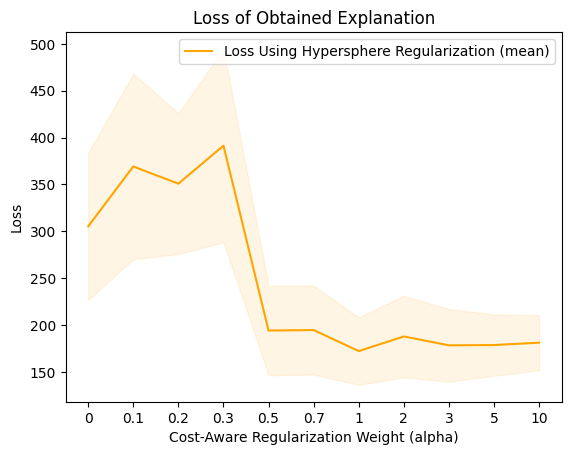

In [ ]:
loss_cavae_mean = np.mean(np.array(results_cavae).transpose(2,0,1)[2], axis=1)
loss_cavae_std = np.std(np.array(results_cavae).transpose(2,0,1)[2], axis=1)

plt.plot(loss_cavae_mean, label='Loss Using Hypersphere Regularization (mean)', color='orange')
plt.fill_between(range(len(loss_cavae_mean)), loss_cavae_mean - 1.96 * loss_cavae_std/(50**0.5), loss_cavae_mean + 1.96 * loss_cavae_std/(50**0.5), color='orange', alpha=0.1)

# Customize the plot as needed
plt.xticks(range(11), [0, 0.1, 0.2, 0.3, 0.5, 0.7, 1, 2, 3, 5, 10])
plt.xlabel('Cost-Aware Regularization Weight (alpha)')
plt.ylabel('Loss')
plt.title('Loss of Obtained Explanation')
plt.legend()

# Show the plot
plt.show()

### Impact of the __plausibility regularization__

In [34]:
from src.counterfactual.parallel_experiments import get_parallel_metrics

In [35]:
betas = [0, 0.1, 0.3, 0.5, 1, 3, 5, 10, 30, 50, 100]
validation_indices = []
for k in range(40):
    init_idx = rd.randint(0, len(dataset_test_cnn)-1)
    while init_idx in [validation_indices[i][0] for i in range(len(validation_indices))]:
        init_idx = rd.randint(0, len(dataset_test_cnn)-1)
    alter_idx = rd.randint(0, len(dataset_test_cnn)-1)
    while torch.equal(dataset_test_cnn[init_idx][2], dataset_test_cnn[alter_idx][2]):
        alter_idx = rd.randint(0, len(dataset_test_cnn)-1)
    validation_indices.append([init_idx, alter_idx])

In [36]:
results_sphere = [None for _ in range(len(betas))]
results_center = [None for _ in range(len(betas))]
results_none = [None for _ in range(len(betas))]

for i, beta in enumerate(betas):

    result = get_parallel_metrics(vae_2, cnn, dataset_test_cnn, "absolute", "feature", 1, "sphere", beta, 0.003, validation_indices, metrics = ["stability", "reconstruction", "loss"])

    results_sphere[i] = result
    print("sphere, ", i)

    result = get_parallel_metrics(vae_2, cnn, dataset_test_cnn, "absolute", "feature", 1, "center", beta, 0.003, validation_indices, metrics = ["stability", "reconstruction", "loss"])

    results_center[i] = result
    print("center, ", i)

    result = get_parallel_metrics(vae_2, cnn, dataset_test_cnn, "absolute", "feature", 1, "none", beta, 0.003, validation_indices, metrics = ["stability", "reconstruction", "loss"])

    results_none[i] = result
    print("none, ", i)

#### __Stability__ metric

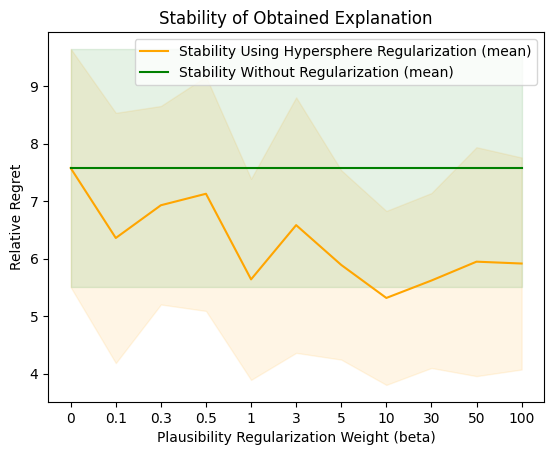

In [42]:
stability_sphere_mean = 100*np.mean(np.array(results_sphere).transpose(2,0,1)[0], axis=1)
stability_sphere_std = 100*np.std(np.array(results_sphere).transpose(2,0,1)[0], axis=1)

stability_none_mean = 100*np.mean(np.array(results_none).transpose(2,0,1)[0], axis=1)
stability_none_std = 100*np.std(np.array(results_none).transpose(2,0,1)[0], axis=1)

plt.plot(stability_sphere_mean, label='Stability Using Hypersphere Regularization (mean)', color='orange')
plt.fill_between(range(len(stability_sphere_mean)), stability_sphere_mean - 1.96 * stability_sphere_std/(40**0.5), stability_sphere_mean + 1.96 * stability_sphere_std/(40**0.5), color='orange', alpha=0.1)

plt.plot(stability_none_mean, label='Stability Without Regularization (mean)', color='green')
plt.fill_between(range(len(stability_none_mean)), stability_none_mean - 1.96 * stability_none_std/(40**0.5), stability_none_mean + 1.96 * stability_none_std/(40**0.5), color='green', alpha=0.1)

# Customize the plot as needed
plt.xticks(range(11), [0, 0.1, 0.3, 0.5, 1, 3, 5, 10, 30, 50, 100])
plt.xlabel('Plausibility Regularization Weight (beta)')
plt.ylabel('Relative Regret')
plt.title('Stability of Obtained Explanation')
plt.legend()

# Show the plot
plt.show()

#### __Reconstruction__ metric

Here, we use the classical outlier detection metric based on the reconstruction error of the VAE when evaluated on the image

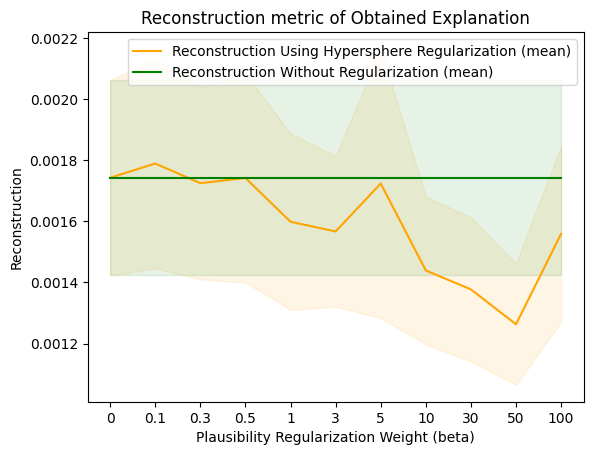

In [69]:
reconstruction_sphere_mean = np.mean(np.array(results_sphere).transpose(2,0,1)[1], axis=1)
reconstruction_sphere_std = np.std(np.array(results_sphere).transpose(2,0,1)[1], axis=1)

reconstruction_none_mean = np.mean(np.array(results_none).transpose(2,0,1)[1], axis=1)
reconstruction_none_std = np.std(np.array(results_none).transpose(2,0,1)[1], axis=1)

plt.plot(reconstruction_sphere_mean, label='Reconstruction Using Hypersphere Regularization (mean)', color='orange')
plt.fill_between(range(len(reconstruction_sphere_mean)), reconstruction_sphere_mean - 1.96 * reconstruction_sphere_std/(40**0.5), reconstruction_sphere_mean + 1.96 * reconstruction_sphere_std/(40**0.5), color='orange', alpha=0.1)

plt.plot(reconstruction_none_mean, label='Reconstruction Without Regularization (mean)', color='green')
plt.fill_between(range(len(reconstruction_none_mean)), reconstruction_none_mean - 1.96 * reconstruction_none_std/(40**0.5), reconstruction_none_mean + 1.96 * reconstruction_none_std/(40**0.5), color='green', alpha=0.1)

# Customize the plot as needed
plt.xticks(range(11), [0, 0.1, 0.3, 0.5, 1, 3, 5, 10, 30, 50, 100])
plt.xlabel('Plausibility Regularization Weight (beta)')
plt.ylabel('Reconstruction')
plt.title('Reconstruction metric of Obtained Explanation')
plt.legend()

# Show the plot
plt.show()

#### Explanation __loss__

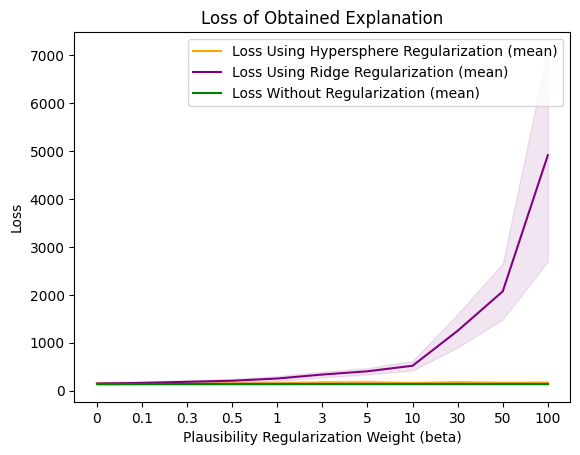

In [59]:
Loss_sphere_mean = np.mean(np.array(results_sphere).transpose(2,0,1)[2], axis=1)
Loss_sphere_std = np.std(np.array(results_sphere).transpose(2,0,1)[2], axis=1)

Loss_center_mean = np.mean(np.array(results_center).transpose(2,0,1)[2], axis=1)
Loss_center_std = np.std(np.array(results_center).transpose(2,0,1)[2], axis=1)

Loss_none_mean = np.mean(np.array(results_none).transpose(2,0,1)[2], axis=1)
Loss_none_std = np.std(np.array(results_none).transpose(2,0,1)[2], axis=1)

plt.plot(Loss_sphere_mean, label='Loss Using Hypersphere Regularization (mean)', color='orange')
plt.fill_between(range(len(Loss_sphere_mean)), Loss_sphere_mean - 1.96 * Loss_sphere_std/(40**0.5), Loss_sphere_mean + 1.96 * Loss_sphere_std/(40**0.5), color='orange', alpha=0.1)

plt.plot(Loss_center_mean, label='Loss Using Ridge Regularization (mean)', color='purple')
plt.fill_between(range(len(Loss_center_mean)), Loss_center_mean - 1.96 * Loss_center_std/(40**0.5), Loss_center_mean + 1.96 * Loss_center_std/(40**0.5), color='purple', alpha=0.1)

plt.plot(Loss_none_mean, label='Loss Without Regularization (mean)', color='green')
plt.fill_between(range(len(Loss_none_mean)), Loss_none_mean - 1.96 * Loss_none_std/(40**0.5), Loss_none_mean + 1.96 * Loss_none_std/(40**0.5), color='green', alpha=0.1)

# Customize the plot as needed
plt.xticks(range(11), [0, 0.1, 0.3, 0.5, 1, 3, 5, 10, 30, 50, 100])
plt.xlabel('Plausibility Regularization Weight (beta)')
plt.ylabel('Loss')
plt.title('Loss of Obtained Explanation')
plt.legend()

# Show the plot
plt.show()

### __Stability__ metric for __adversarial__ explanations

In [70]:
validation_indices = []
for k in range(40):
    init_idx = rd.randint(0, len(dataset_test_cnn)-1)
    while init_idx in [validation_indices[i][0] for i in range(len(validation_indices))]:
        init_idx = rd.randint(0, len(dataset_test_cnn)-1)
    alter_idx = rd.randint(0, len(dataset_test_cnn)-1)
    while torch.equal(dataset_test_cnn[init_idx][2], dataset_test_cnn[alter_idx][2]):
        alter_idx = rd.randint(0, len(dataset_test_cnn)-1)
    validation_indices.append([init_idx, alter_idx])

In [31]:
results_adv = get_parallel_metrics(vae_2, cnn, dataset_test_cnn, "absolute", "feature", 1, "sphere", 10, 0.01, validation_indices, vae_for_mdmm=0, metrics = ['stability', 'reconstruction'])

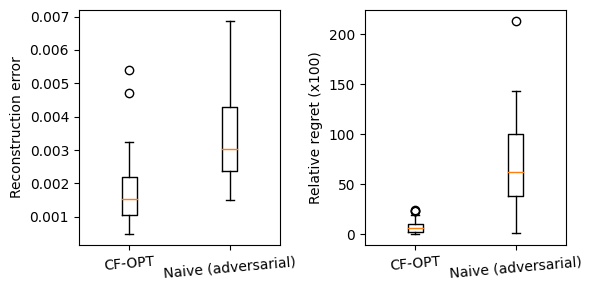

In [51]:
data = [np.array(results_sphere).transpose(2,0,1)[1][0], np.array(results_adv).transpose(1,0)[1], 100*np.array(results_sphere).transpose(2,0,1)[0][0], 100*np.array(results_adv).transpose(1,0)[0]]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))

# Subplot 1
axes[0].boxplot(data[:2], labels=['CF-OPT', 'Naive (adversarial)'])
axes[0].set_ylabel('Reconstruction error')
axes[0].set_xticks([1, 2])  # Set tick positions
axes[0].set_xticklabels(['CF-OPT', 'Naive (adversarial)'], rotation=5)
# Subplot 2
axes[1].boxplot(data[2:], labels=['CF-OPT', 'Naive (adversarial)'])
axes[1].set_ylabel('Relative regret (x100)')
axes[1].set_xticks([1, 2])  # Set tick positions
axes[1].set_xticklabels(['CF-OPT', 'Naive (adversarial)'], rotation=5)

plt.tight_layout()
plt.show() 